# Data analysis of server(s) workload jobs

## Interpreting the data

If we take a look at the Yahoo! trace, the provided format is `job_submission_time` `nr_of_tasks_in_job` `average_task_duration` `the_runtime_of_each_task`. This only allows us to model the "Job Arrival Process" \[1], ie. the Arrival Rate, Inter-arrival Time, and Actual Runtime. However, Job Cancellation is unknown and cannot be measured from these traces. Additionally, we can analyse the job modelling characteristics Bag Of Tasks, Burstiness, and Periodicity \[1]. "Job Execution Process" \[1] details such as Job Size (# Cores), Memory Usage, and User Behaviour are not recorded in the trace, and thus cannot be analysed.

## Problems with the trace data

When examining the `job_submission_time` and `the_runtime_of_each_task` fields of the trace, the time increment is not specified. This information is important to determine to accurately interperet the data. When looking at the source for the Yahoo! workload trace \[2], the  trace comes from a cluster of approximately 2000 machines at Yahoo! (YH trace), covers three weeks in late February 2009 and early March 2009, and contains around 30,000 jobs. It also details that the running time is in task-seconds of map and reduce functions. Thus, for the `the_runtime_of_each_task` field, we can make the assumption that the floating point number is in seconds. If we make the assumption that the `job_submission_time`, we would expect the last job submission time to be close to the number of seconds in 3 weeks, which is `60 x 60 x 24 x 7 x 3 = 1814400`. When looking at the last job record in the Yahoo! trace `YH.tr`, the `job_submission_time` is 181440, thus we can make the assumption that the submission time is measure in tens of seconds.

Unfortunately, when doing the same thing for the Facebook trace `FB.tr`, the last job record has a submit time of 388171, this is vastly different to the number of seconds in 6 months, which is approximately `60 x 60 x 24 x 30 x 6 = 15552000`. It also shares no regular pattern to the last job submit time. This issue of unknown time units must be resolved before analysing the Facebook trace, and potentially the other traces.

*\[1] F. Ian, "WORKLOAD CHARACTERISATION FOR CLOUD RESOURCE MANAGEMENT," School of Engineering Macquarie University, 2020, pp. 4-7.*
 
*\[2] Y. Chen, A. Ganapathi, R. Griffith and R. Katz, "The Case for Evaluating MapReduce Performance Using Workload Suites," 2011 IEEE 19th Annual International Symposium on Modelling, Analysis, and Simulation of Computer and Telecommunication Systems, 2011, pp. 390-399, doi: 10.1109/MASCOTS.2011.12.*

## Importing the data

The first step is to import the data from the `jobs.csv` file. This file is generated from the `*.tr` trace files using the preprocessing script `process-trace.sh`. 

The `pandas` library is used to import the CSV file as a Dataframe. Pandas is a data science tool used for exploring and manipulating data. The `numpy` library is also imported to be used in conjuction with `pandas` to manipulate the Dataframe.

In [53]:
import numpy as np
import pandas as pd

with open('preprocessing/jobs.csv') as file:
    data = pd.read_csv(file)

data.set_index('job_id', inplace=True)

## How the data looks

As we can see below, the `jobs.csv` data has four fields: fields: 'job_id', 'job_submission_time', 'nr_of_tasks_in_job', and 'average_task_duration'.

Starting from time 0, each record contains a timestamp for either when a new job is submitted to the system. This give us a list of jobs in the workload trace.

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21030 entries, 0 to 21029
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_submission_time    21030 non-null  float64
 1   nr_of_tasks_in_job     21030 non-null  int64  
 2   average_task_duration  21030 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 657.2 KB


In [55]:
data.head()

,job_submission_time,nr_of_tasks_in_job,average_task_duration
job_id,,,
0,12.482,204,86.959510
1,24.967,90,189.782879
2,37.271,418,133.646689
3,49.507,18,27.561830
4,61.758,346,71.183756


In [56]:
data.tail()

,job_submission_time,nr_of_tasks_in_job,average_task_duration
job_id,,,
21025,259169.0,57,85.524268
21026,259182.0,173,92.247241
21027,259194.0,47,25.590236
21028,259206.0,451,111.533691
21029,259218.0,286,12.196060


## Statistics

Below are some general statistical mesaures of the data.

In [57]:
data.describe()

,job_submission_time,nr_of_tasks_in_job,average_task_duration
count,21030.000000,21030.000000,21030.000000
mean,129619.065930,272.928388,162.195030
std,74833.548174,904.947689,1087.374789
min,12.482000,1.000000,0.073148
25%,64815.550000,52.000000,19.332018
50%,129621.500000,124.000000,47.664328
75%,194422.750000,253.000000,98.254062
max,259218.000000,51834.000000,96821.360129


## Job Modelling Characteristics

### Measuring the Bag of Task Jobs

Bag of Tasks (BOT) refers to the behaviour of consecutive job submissions from the same user within a specified time period \[1].

To find the jobs which exhibit the BOT characteristic, we filter the data set to only jobs with more than 1 task in the job.



In [58]:
bot_jobs = data.query('nr_of_tasks_in_job > 1')
bot_jobs.describe()

,job_submission_time,nr_of_tasks_in_job,average_task_duration
count,20912.000000,20912.000000,20912.000000
mean,129636.490544,274.462796,162.028196
std,74829.495840,907.266163,1088.992610
min,12.482000,2.000000,0.074059
25%,64858.800000,53.000000,19.317237
50%,129609.000000,125.000000,47.625370
75%,194416.250000,254.000000,98.274271
max,259218.000000,51834.000000,96821.360129


In [59]:
isolated_jobs = data.query('nr_of_tasks_in_job == 1')
isolated_jobs.describe()

,job_submission_time,nr_of_tasks_in_job,average_task_duration
count,118.000000,118.0,118.000000
mean,126531.069898,1.0,191.761418
std,75806.642544,0.0,749.874668
min,714.948000,1.0,0.073148
25%,58418.450000,1.0,22.974308
50%,129997.000000,1.0,52.844581
75%,193837.250000,1.0,96.720542
max,255928.000000,1.0,6382.246369


### Results:

We find that there are 23100 BOT jobs and 1162 isolated jobs from a total of 24262 jobs in the Yahoo! workload trace.

The mean number of tasks in a BOT Job is ~42, with a median of 16. The standard deviation for the number of tasks is relatively large, at 157.

## Arrival Rate

Calculate the average daily arrival rate for the dataset.

In [65]:
days = 0
n = 1
minute = 6
day = minute*60*24
freq = 60*minute

sumArrivalRate = np.zeros(int(day/freq))

for i, job in enumerate(data['job_submission_time']):
    days = int(job/(day))
    n = int((job - (days*day))/freq)
    sumArrivalRate[n] += data['nr_of_tasks_in_job'][i]
    # if days > 0:
    #     break

avgArrivalRate = sumArrivalRate
for i, rate in enumerate(avgArrivalRate):
            avgArrivalRate[i] = rate/days

ar = pd.DataFrame(avgArrivalRate, columns=['rate'])
ar


,rate
0,8302.566667
1,7140.533333
2,7752.866667
3,7430.366667
4,7266.933333
5,10616.366667
6,8217.800000
7,9072.933333
8,6700.733333
9,7157.800000


### Distribution Fitting
Find the best fitting distribution with the lowest SSE and generate a PDF for it.

In [66]:
import scipy.stats
import fitDistribution as fd

dist, params, results = fd.best_fit_distribution(ar)

pdf = fd.make_pdf(dist, params)

print("The best fitting dis"dist.name

#### Fitting results from the other distributions:

In [73]:
import pprint as pp

pp.pprint(results)

[{'alpha': {'arg': (5.837535703541398,),
            'loc': 3493.539966092274,
            'scale': 25383.57626207688,
            'sse': 0.00010790339445285223}},
 {'anglit': {'arg': (),
             'loc': 8368.677138744895,
             'scale': 3053.8205847125137,
             'sse': 0.00011205148429129825}},
 {'arcsine': {'arg': (),
              'loc': 6689.428560184008,
              'scale': 3926.938106482659,
              'sse': 0.0001139894045010803}},
 {'beta': {'arg': (2.503301986281786, 28.50450379373553),
           'loc': 6538.7624688505275,
           'scale': 17750.003622166525,
           'sse': 0.00010758115348751237}},
 {'betaprime': {'arg': (1597.1645492436521, 103.99350601516514),
                'loc': -6.368017047648664,
                'scale': 514.3547507513556,
                'sse': 0.00010798066394891158}},
 {'bradford': {'arg': (1.0961702922038858,),
               'loc': 6700.733317954169,
               'scale': 3915.633393848132,
               'sse': 

### Custom PDF generation for testing

In [70]:
d = scipy.stats.gumbel_l
d_param = d.fit(ar)
d_pdf = fd.make_pdf(d, (16.2, 5.03))

### Plotting Arrival Rate

Below we plot the arrival rate and the pdf from the fitted distribution with the lowest SSE.

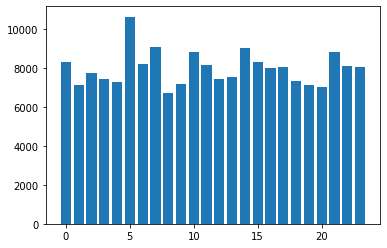

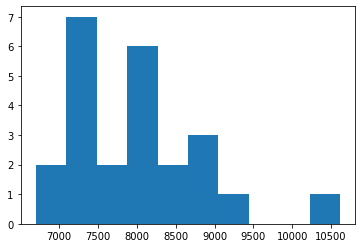

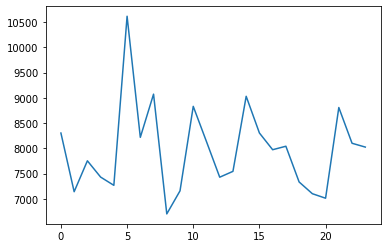

dgamma


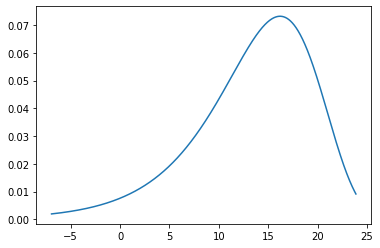

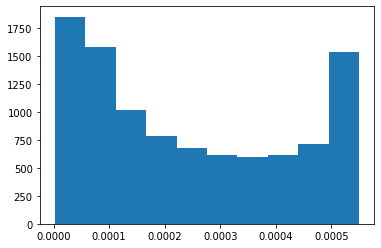

In [71]:
import matplotlib.pyplot as plt

plt.bar(ar.index, ar['rate'])
plt.show()
plt.hist(ar)
plt.show()
plt.plot(ar)
plt.show()

print(dist.name)
plt.plot(pdf)
plt.show()
plt.hist(pdf)
plt.show()

